In [ ]:
#ha7 CLIP

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-b9r4szon
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-b9r4szon
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 2.5.0+cu121


<ipython-input-2-cc4b7f78b657>:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging


In [ ]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [ ]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7890f0d75480>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [ ]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [ ]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

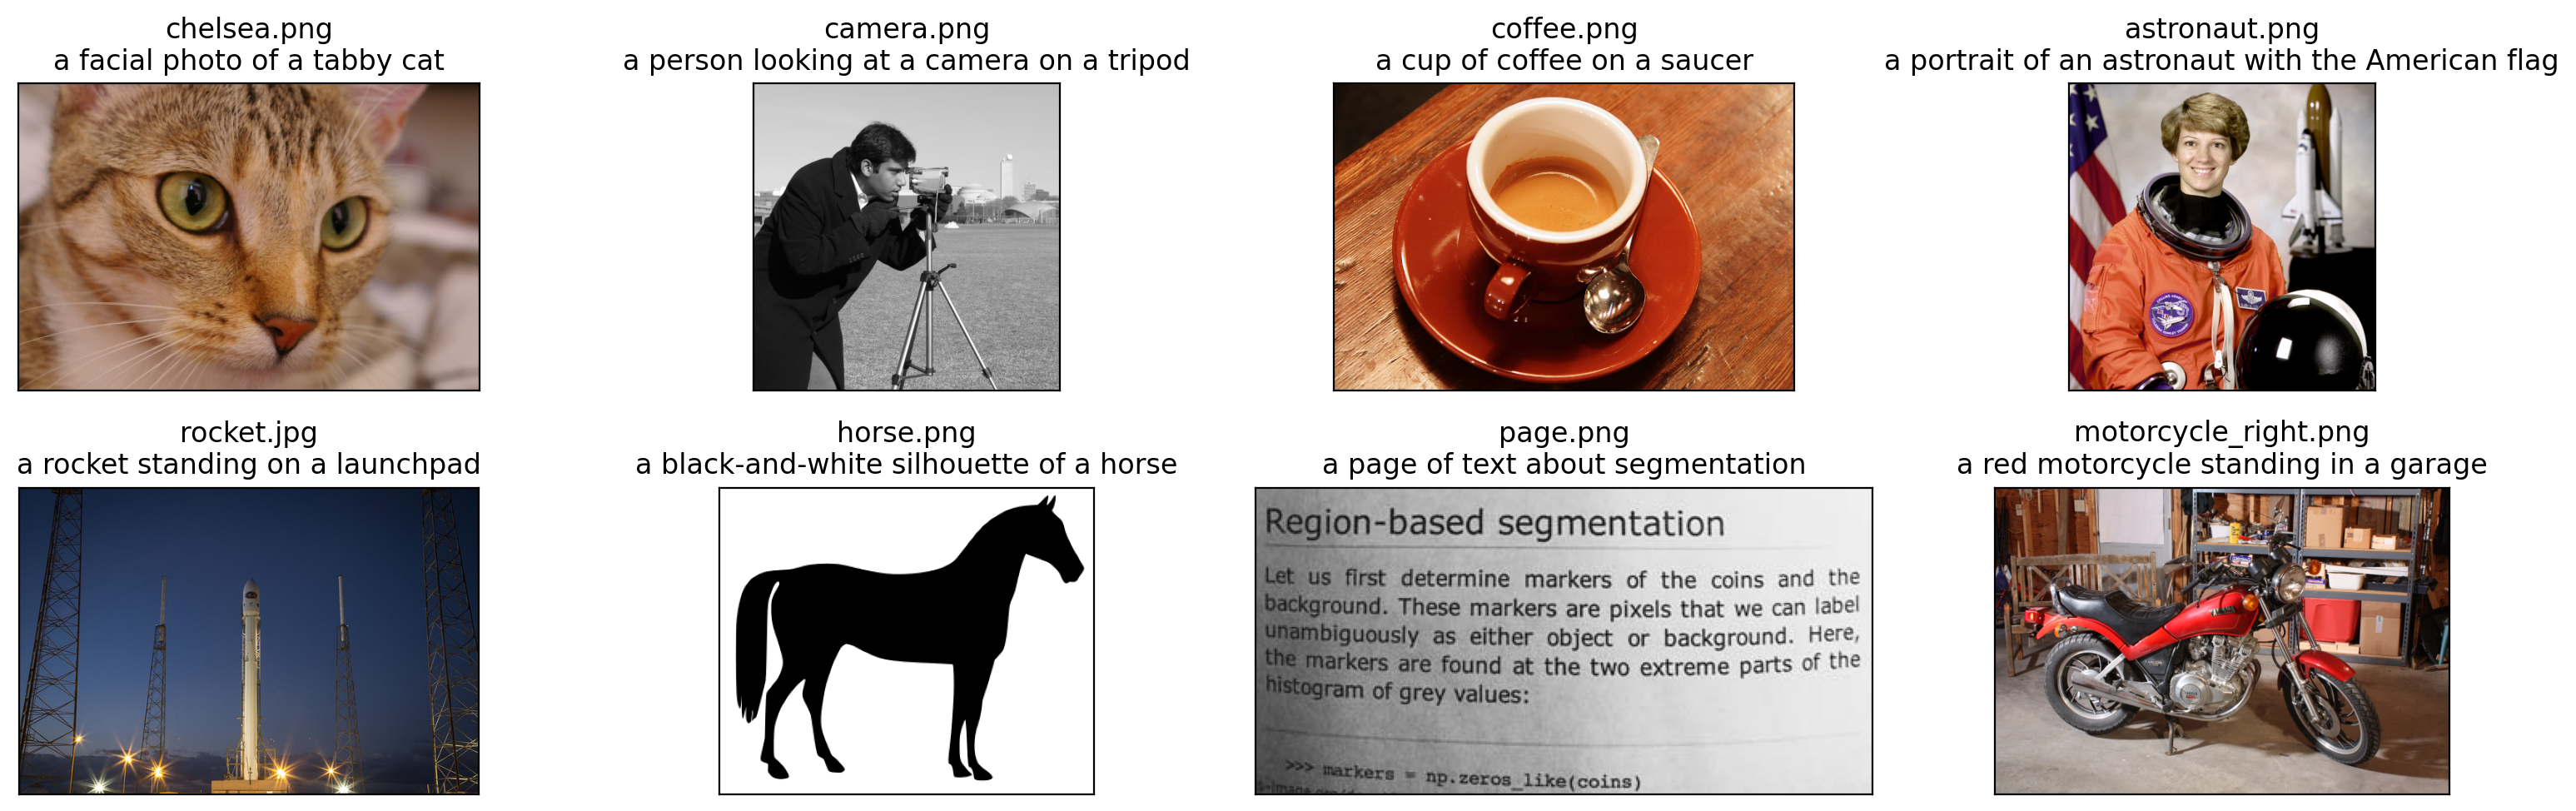

In [ ]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))
skimage_data_dir=str(skimage.__file__).split('__init__.py')[0]+'/data/'

for filename in [filename for filename in os.listdir(skimage_data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage_data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


In [ ]:
image_input = torch.tensor(np.stack(images)).cuda()

text_tokens = clip.tokenize([desc for desc in texts]).cuda()

In [ ]:
print(image_input.shape)
print(text_tokens.shape)

torch.Size([8, 3, 224, 224])
torch.Size([8, 77])


In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [ ]:
print(image_features.shape)
print(text_features.shape)

torch.Size([8, 512])
torch.Size([8, 512])


In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

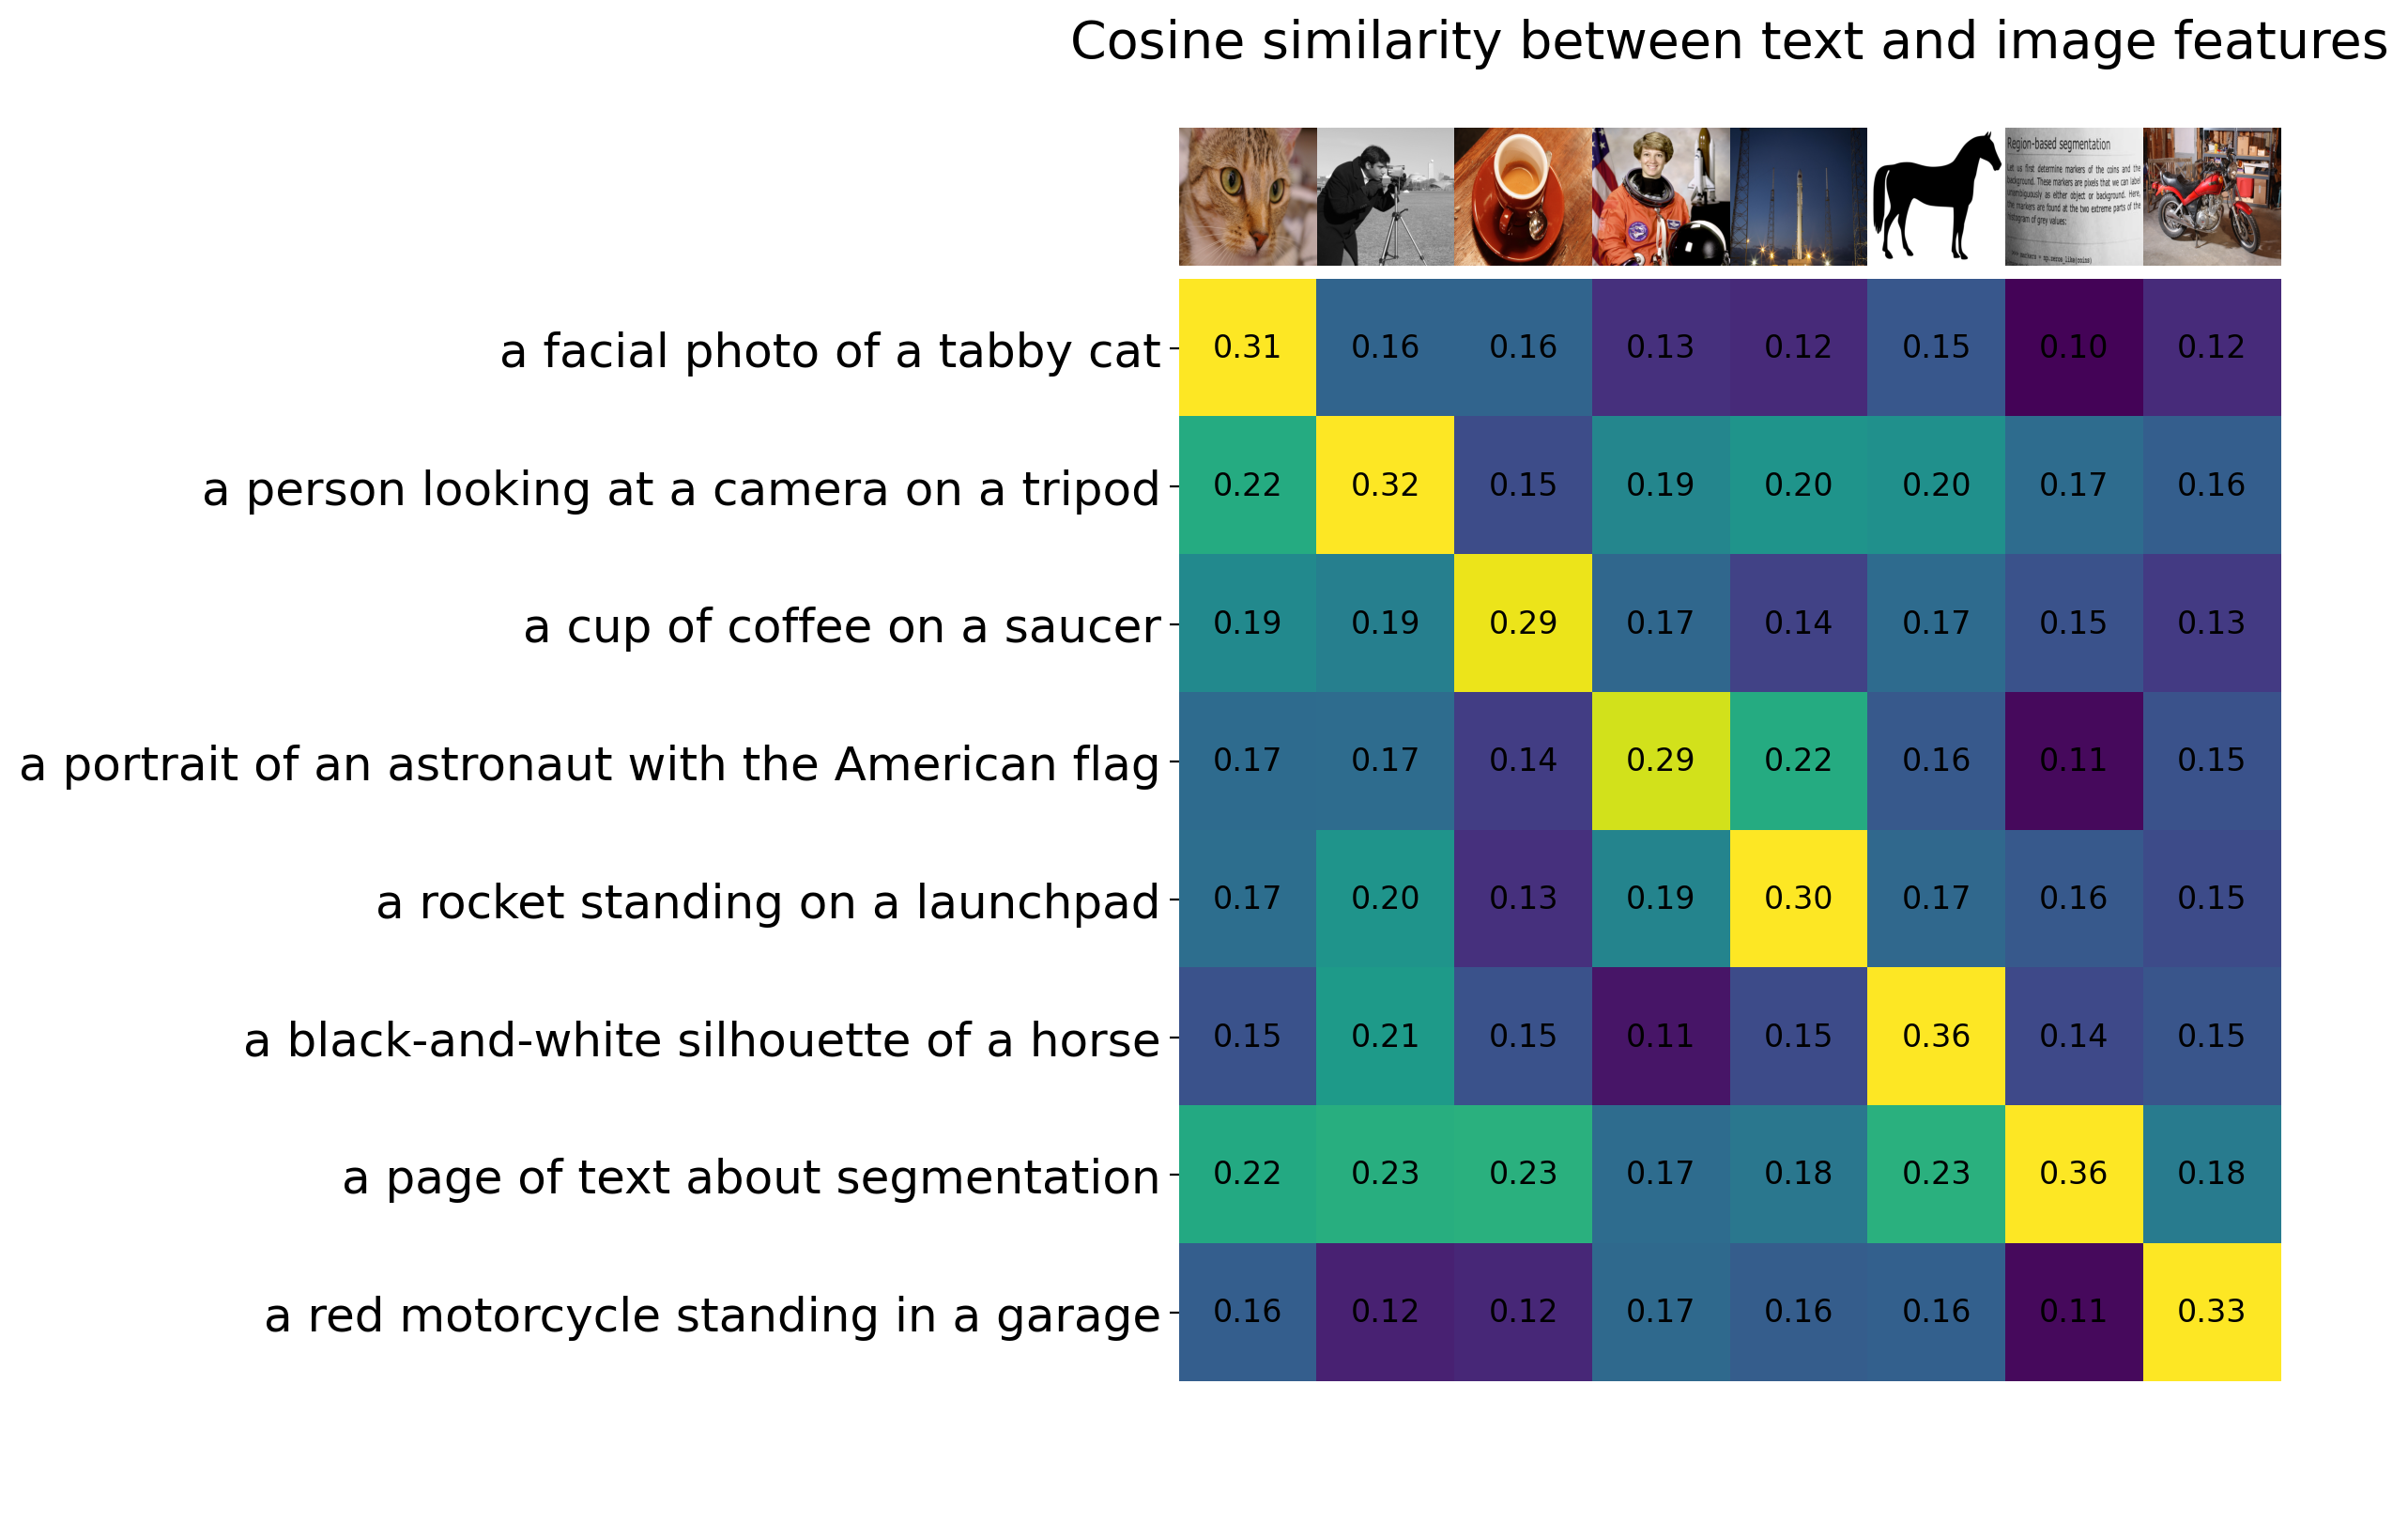

In [ ]:
count = len(descriptions)

plt.figure(figsize=(15, 10))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)




In [ ]:
preprocess

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
)

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

cifar100_testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=preprocess)
cifar100_test_loader = DataLoader(cifar100_testset, batch_size=2000, shuffle=False)

class_names = cifar100_testset.classes
print("Classes:", class_names)

Files already downloaded and verified
Classes: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip'

In [ ]:
simple_templates = [f"a photo of a {class_name}" for class_name in class_names]

templates = [
    'a photo of a {}.',
    'a blurry photo of a {}.',
    'a black and white photo of a {}.',
    'a low contrast photo of a {}.',
    'a high contrast photo of a {}.',
    'a bad photo of a {}.',
    'a good photo of a {}.',
    'a photo of a small {}.',
    'a photo of a big {}.',
    'a photo of the {}.',
    'a blurry photo of the {}.',
    'a black and white photo of the {}.',
    'a low contrast photo of the {}.',
    'a high contrast photo of the {}.',
    'a bad photo of the {}.',
    'a good photo of the {}.',
    'a photo of the small {}.',
    'a photo of the big {}.',
]

ensemble_templates = [
    [template.format(class_name) for template in templates] for class_name in class_names
]

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device)

with torch.no_grad():
    simple_text_tokens = clip.tokenize(simple_templates).to(device)
    all_ensemble_text_tokens = clip.tokenize([template for sublist in ensemble_templates for template in sublist]).to(device)

    simple_text_features = model.encode_text(simple_text_tokens)
    ensemble_text_features = model.encode_text(all_ensemble_text_tokens)

    simple_text_features /= simple_text_features.norm(dim=-1, keepdim=True)
    ensemble_text_features /= ensemble_text_features.norm(dim=-1, keepdim=True)

ensemble_mean_text_features = []
index = 0
for i in range(len(class_names)):
    current_ensemble_features = ensemble_text_features[index:index + len(templates)]
    index += len(templates)

    mean_feature = current_ensemble_features.mean(dim=0)
    ensemble_mean_text_features.append(mean_feature)

ensemble_mean_text_features = torch.stack(ensemble_mean_text_features).to(device)


In [ ]:
def accuracy(predicted, labels):
    predictions, id = torch.max(predicted, dim=1)
    return torch.tensor(torch.sum(id == labels).item() / len(predicted))
accuracy_per_batch_simple = []
accuracy_per_batch_ensemble = []
current_epoch = 1

for images, labels in cifar100_test_loader:
    print(f'{current_epoch}/{len(cifar100_test_loader)}')
    with torch.no_grad():
        images = images.to(device)
        labels = labels.to(device)

        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        simple_pred_logits = image_features @ simple_text_features.T
        simple_pred_probs = simple_pred_logits.softmax(dim=-1)

        ensemble_pred_logits = image_features @ ensemble_mean_text_features.T
        ensemble_pred_probs = ensemble_pred_logits.softmax(dim=-1)

        simple_acc = accuracy(simple_pred_probs, labels)
        ensemble_acc = accuracy(ensemble_pred_probs, labels)

        print(f'Accuracy at this batch (Simple Template): {simple_acc.item() * 100}%')
        print(f'Accuracy at this batch (Ensemble Template): {ensemble_acc.item() * 100}%')

        accuracy_per_batch_simple.append(simple_acc)
        accuracy_per_batch_ensemble.append(ensemble_acc)

    current_epoch += 1

overall_accuracy_simple = torch.stack(accuracy_per_batch_simple).mean().item()
overall_accuracy_ensemble = torch.stack(accuracy_per_batch_ensemble).mean().item()

print(f'\nOverall accuracy (Simple Template): {overall_accuracy_simple * 100}%')
print(f'Overall accuracy (Ensemble Template): {overall_accuracy_ensemble * 100}%')

1/5
Accuracy at this batch (Simple Template): 62.449997663497925%
Accuracy at this batch (Ensemble Template): 64.74999785423279%
2/5
Accuracy at this batch (Simple Template): 61.250001192092896%
Accuracy at this batch (Ensemble Template): 63.70000243186951%
3/5
Accuracy at this batch (Simple Template): 61.549997329711914%
Accuracy at this batch (Ensemble Template): 64.34999704360962%
4/5
Accuracy at this batch (Simple Template): 61.400002241134644%
Accuracy at this batch (Ensemble Template): 64.99999761581421%
5/5
Accuracy at this batch (Simple Template): 61.29999756813049%
Accuracy at this batch (Ensemble Template): 64.0500009059906%

Overall accuracy (Simple Template): 61.58999800682068%
Overall accuracy (Ensemble Template): 64.37000036239624%


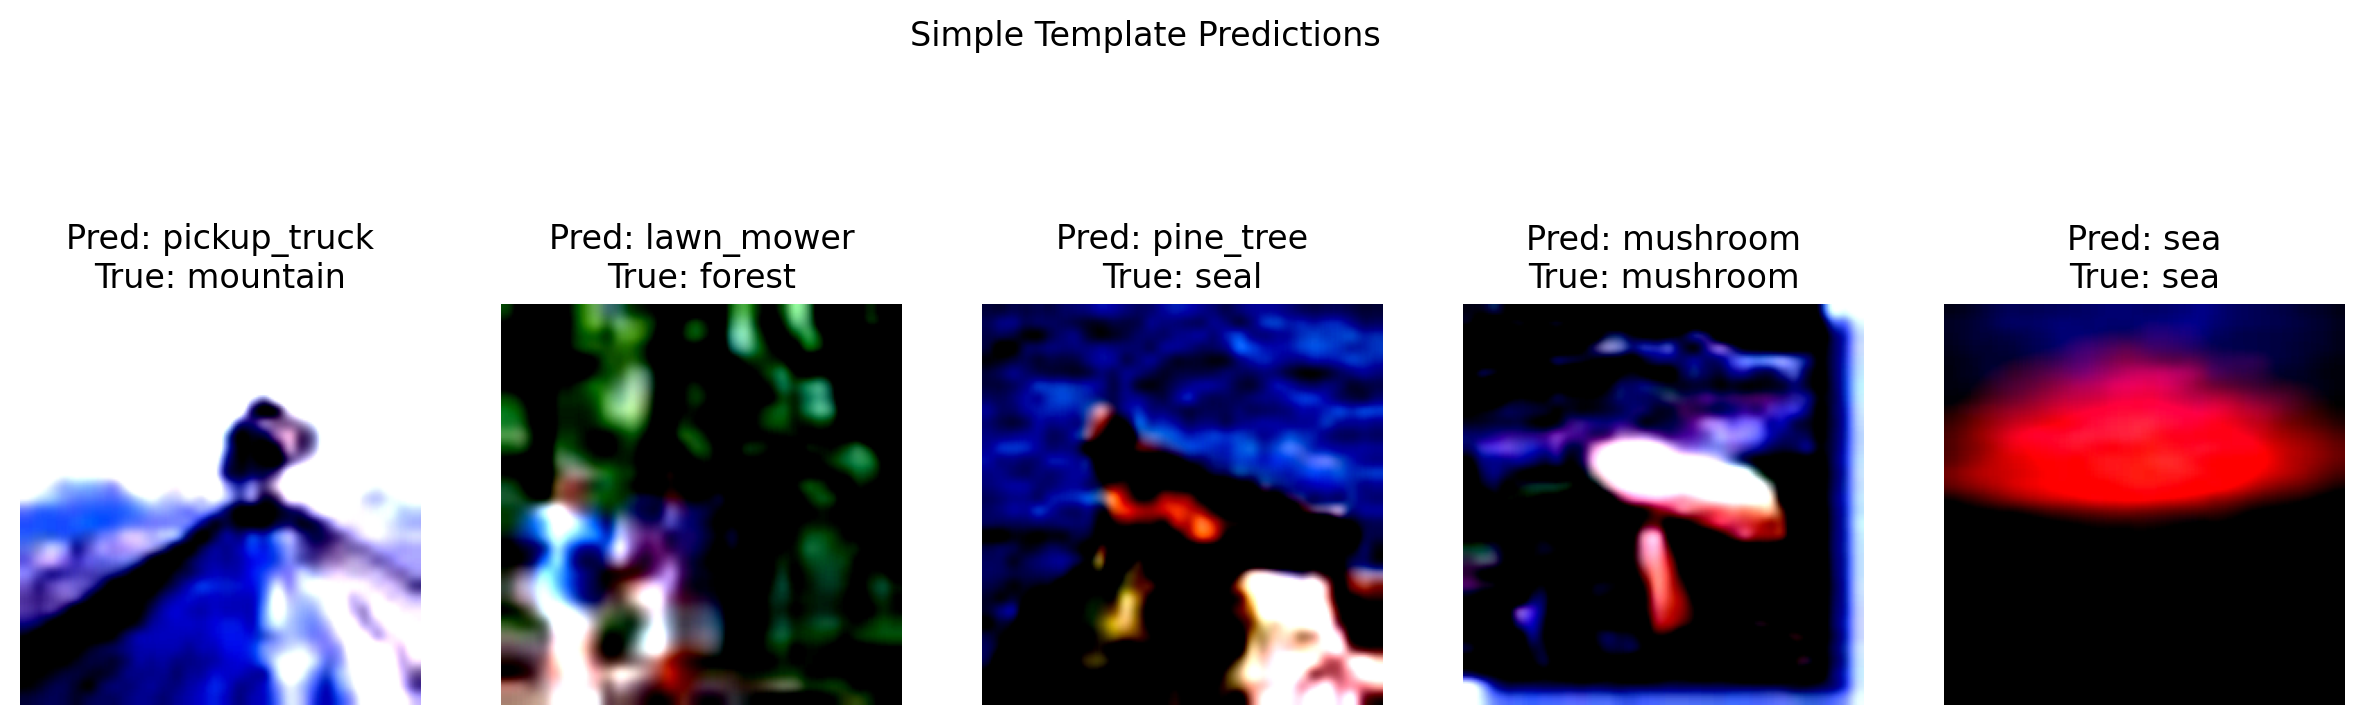

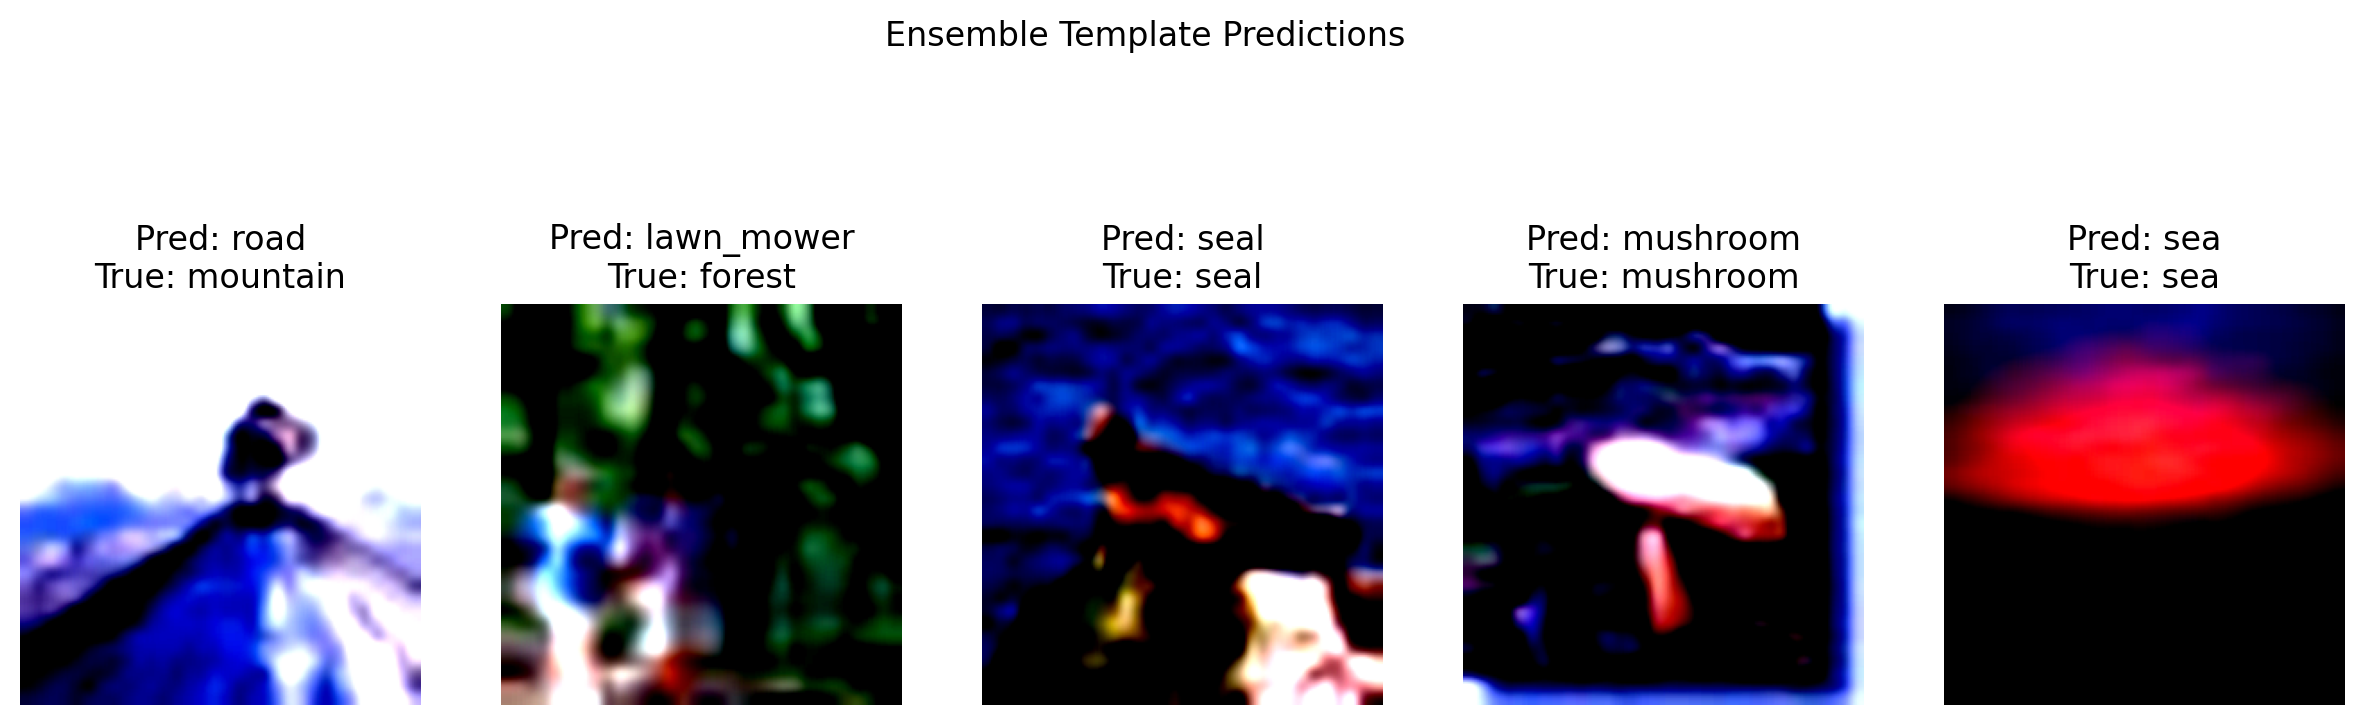

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_images_and_predictions(images, labels, preds, class_names, title="Predictions"):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0).cpu().numpy())
        ax.set_title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

with torch.no_grad():
    images, labels = next(iter(cifar100_test_loader))
    images, labels = images.to(device), labels.to(device)
    image_features = model.encode_image(images)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    simple_pred_logits = image_features @ simple_text_features.T
    simple_pred_probs = simple_pred_logits.softmax(dim=-1)
    simple_preds = torch.argmax(simple_pred_probs, dim=-1)

    ensemble_pred_logits = image_features @ ensemble_mean_text_features.T
    ensemble_pred_probs = ensemble_pred_logits.softmax(dim=-1)
    ensemble_preds = torch.argmax(ensemble_pred_probs, dim=-1)

    show_images_and_predictions(images, labels, simple_preds, class_names, title="Simple Template Predictions")
    show_images_and_predictions(images, labels, ensemble_preds, class_names, title="Ensemble Template Predictions")
